<IPython.core.display.Javascript object>


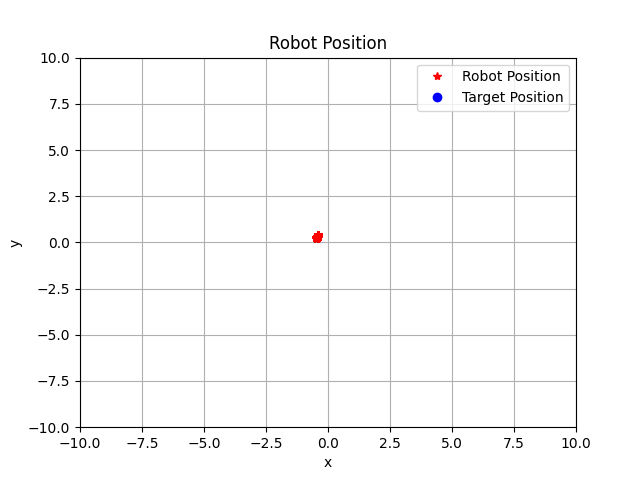

<IPython.core.display.Javascript object>


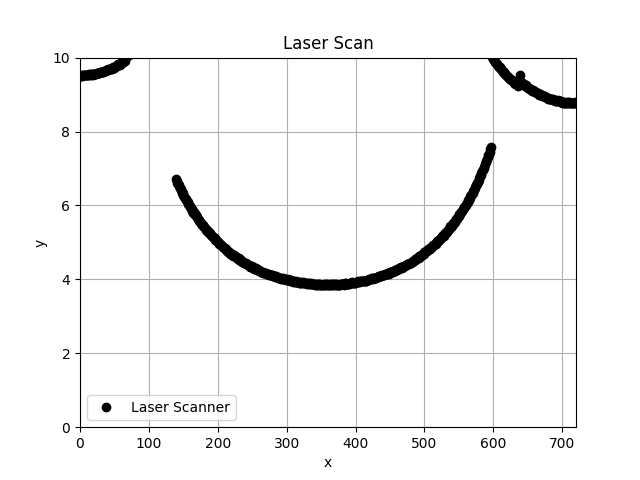

<IPython.core.display.Javascript object>


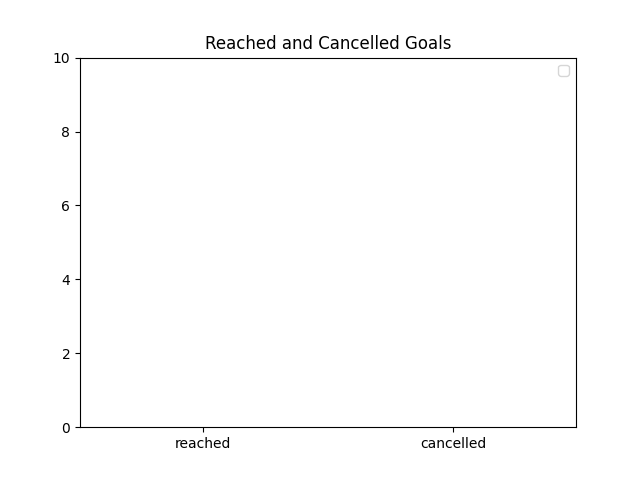

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import rospy
import tf
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from tf.transformations import quaternion_matrix
from assignment_2_2022.msg import PlanningActionGoal, PlanningActionFeedback
import numpy as np
from matplotlib.animation import FuncAnimation

class Visualiser:
    def __init__(self):
         # Create a figure and axes for the robot position plot
        self.fig_1, self.ax_1 = plt.subplots()
        # Create a line for the robot position and set its label to "Robot Position"
        self.ln_robot, = plt.plot([], [], 'r*', label = "Robot Position")
        # Create a line for the target position and set its label to "Target Position"
        self.ln_target, = plt.plot([], [], 'bo', label = "Target Position")
         # Add a legend to the plot with the robot and target positions
        plt.legend(handles=[self.ln_robot, self.ln_target])
         # Enable the grid on the plot
        plt.grid(True)
        
         # Create empty lists to store the robot and target position data
        self.x_data_robot, self.y_data_robot = [], []
        self.x_data_target, self.y_data_target = [], []
        
         # Create a figure and axes for the laser scan plot
        self.fig_2, self.ax_2 = plt.subplots()
        # Create a line for the laser scan data and set its label to "Laser Scanner"
        self.ln_laser, = plt.plot([], [], 'ko', label = "Laser Scanner")
         # Add a legend to the plot with the laser scanner data
        plt.legend(handles=[self.ln_laser])
        # Enable the grid on the plot
        plt.grid(True)
         # Create an empty list to store the laser scan data
        self.laser_scanner = []
    # Define a function to initialize the robot position plot    
    def plot_1(self):
        # Set the x and y limits for the plot
        self.ax_1.set_xlim(-10, 10)
        self.ax_1.set_ylim(-10, 10)
         # Set the title and axis labels for the plot
        self.ax_1.set_title("Robot Position")
        self.ax_1.set_xlabel("x")
        self.ax_1.set_ylabel("y")
        
        # Return the lines for the robot and target positions
        return self.ln_robot, self.ln_target
    # Define a function to initialize the laser scan plot
    def plot_2(self):
        # Set the x and y limits for the plot
        self.ax_2.set_xlim(0, 720)
        self.ax_2.set_ylim(0, 10)  
        # Set the title and axis labels for the plot
        self.ax_2.set_title("Laser Scan")
        self.ax_2.set_xlabel("x")
        self.ax_2.set_ylabel("y")
         # Return the line for the laser scan data 
        return self.ln_laser
    # Define a callback function to handle the robot position data
    def odom_callback(self, msg):
         # Add the robot position data to the respective lists
        self.y_data_robot.append(msg.pose.pose.position.y)
        self.x_data_robot.append(msg.pose.pose.position.x)
    # Define a callback function to handle the target position data    
    def target_callback(self, msg):
         # Clear the target position data lists
        self.y_data_target.clear()
        self.x_data_target.clear()
         # Add the new target
        y = self.y_data_target.append(msg.goal.target_pose.pose.position.y)
        x = self.x_data_target.append(msg.goal.target_pose.pose.position.x)
    # Define a callback function to handle the scanning data     
    def scanner_callback(self, msg):
        self.laser_scanner = list(msg.ranges)
           
    # Define an update plot function to handle goal and robot positions    
    def update_plot_1(self, frame):
        self.ln_robot.set_data(self.x_data_robot, self.y_data_robot)
        self.ln_target.set_data(self.x_data_target, self.y_data_target)
        return self.ln_robot, self.ln_target
    # Define an update plot function to handle scanner data   
    def update_plot_2(self, frame):
        self.ln_laser.set_data(list(np.linspace(0,720,720)),self.laser_scanner)
        
        return self.ln_laser
    
# Initialize the node    
rospy.init_node('odom_visualizer_node')
vis = Visualiser()

# Subscribe odometry, goal, and scanner data
sub_odom = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
sub_target = rospy.Subscriber('/reaching_goal/goal', PlanningActionGoal, vis.target_callback)
sub_laser = rospy.Subscriber('/scan',LaserScan, vis.scanner_callback)

# Create an animated bar chart of the message counts
ani_1 = FuncAnimation(vis.fig_1, vis.update_plot_1, init_func=vis.plot_1, cache_frame_data=False)
ani_2 = FuncAnimation(vis.fig_2, vis.update_plot_2, init_func=vis.plot_2, cache_frame_data=False)
# Display the animated plots in Jupyter Notebook
plt.show(block=True)



#-------------Reached and not Reached Target Numbers--------------------


# Initialize variables to count the number of "reached" and "cancelled" messages
reached = 0
cancelled = 0

# Create a bar chart of the initial message counts
fig, ax = plt.subplots()

# Set the y-axis limits
ax.set_ylim(bottom=0, top=10)

# Add a legend to the chart
ax.legend(loc='upper left', fontsize='large')
draw = ax.bar(["reached", "cancelled"], [reached, cancelled])

# create a callback function to update the counts when feedback is received
def feedback_callback(data):

    global reached, cancelled
    if data.feedback.stat == 'Target cancelled!':  # cancellation status string
        cancelled = cancelled + 1
        
    elif data.feedback.stat == 'Target reached!':  # reached status string
        reached = reached + 1


# Define a function to update the bar chart with the latest message counts
def update_chart(frame):
    global draw, reached, cancelled
    draw = ax.bar(["reached", "cancelled"], [reached, cancelled], color =['blue','red'])
    
sub_counter = rospy.Subscriber('/reaching_goal/feedback', PlanningActionFeedback, feedback_callback)    
    

# Create an animated bar chart of the message counts
ani = FuncAnimation(fig, update_chart, interval=100, cache_frame_data=False)

# Add a title to the chart
ax.set_title('Reached and Cancelled Goals')
ax.legend()
# Display the animated bar chart in Jupyter Notebook
plt.show(block=True) 
